In [ ]:
print("Test notebook connection")

Test notebook connection


In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pytorch_lightning as pl
from torchvision import transforms, datasets
import torch

# **1. Data acquisition**

The images are mostly from Pinterest or other image sharing platforms.


They were downloaded and uploaded to this repository manually, from where this code can access it

# **2. Data analysis**

In [5]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [6]:
bagel_images = load_images_from_folder('images/train/bagel')
burger_images = load_images_from_folder('images/train/burger')
sandwich_images = load_images_from_folder('images/train/sandwich')

In [7]:
len(bagel_images), len(burger_images), len(sandwich_images)

(50, 50, 50)

### Class distribution
We have 50 images of three classes.

The classes are:
- Bagel
- Burger
- Sandwich

The class distribution is equal since we have 50 images in all classes, so there are no class imbalances.



In [9]:
dataset_path = 'images/train'

### Visualizing samples

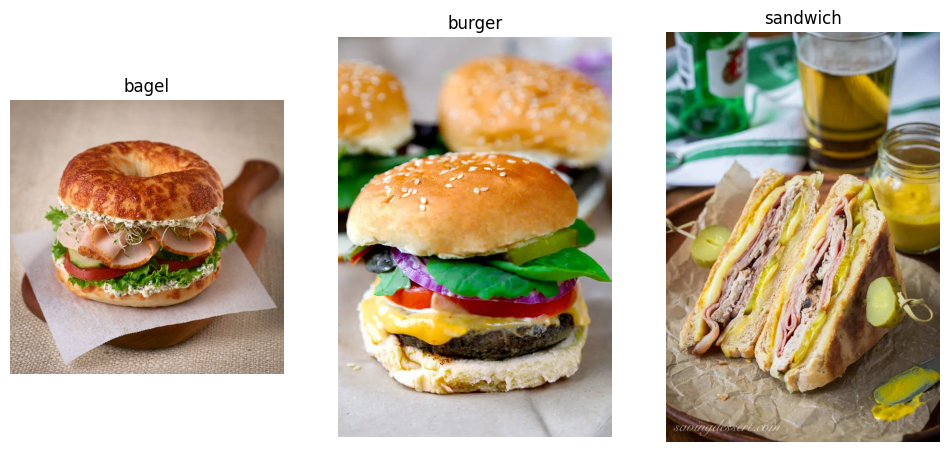

In [10]:
def analyze_dataset(dataset_path):
    class_samples = {}
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        
        if os.path.isdir(class_path):
            image_files = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
            class_samples[class_name] = [os.path.join(class_path, img) for img in image_files[:5]]

    plt.figure(figsize=(12, 6))
    for idx, (class_name, samples) in enumerate(class_samples.items()):
        plt.subplot(1, len(class_samples), idx + 1)
        for img_path in samples:
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
    plt.show()

analyze_dataset(dataset_path)

### Check image corruption

In [11]:
def check_image_corruption(dataset_path):
    corrupted_images = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                if os.path.isfile(img_path):
                    try:
                        img = Image.open(img_path)
                        img.verify()
                    except Exception as e:
                        corrupted_images.append(img_path)
                        print(f"Corrupted image: {img_path}")

    if corrupted_images:
        print(f"Total corrupted images: {len(corrupted_images)}")
    else:
        print("No corrupted images found.")

check_image_corruption('images/train')
check_image_corruption('images/test')
check_image_corruption('images/val')

No corrupted images found.
No corrupted images found.
No corrupted images found.


### Statistical analysis

In [12]:
import numpy as np

def calculate_image_statistics(dataset_path):
    widths, heights = [], []
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if os.path.isfile(img_path):
                    img = Image.open(img_path)
                    widths.append(img.width)
                    heights.append(img.height)
    
    if widths and heights:
        print(f"Average width: {np.mean(widths)}, Average height: {np.mean(heights)}")
    else:
        print("No valid images found.")

calculate_image_statistics('images/train')
calculate_image_statistics('images/val')


Average width: 582.9066666666666, Average height: 703.9866666666667
Average width: 1152.0, Average height: 896.0


# **3. Data cleansing and preparation**

In [13]:
class BurgerBagelSandwichDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, resolution=224, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.resolution = resolution
        self.num_workers = num_workers

        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=self.resolution, scale=(0.25, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.val_transform = transforms.Compose([
            transforms.Resize(size=self.resolution, antialias=True),
            transforms.CenterCrop(size=self.resolution),
            transforms.ToTensor(),
        ])

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = datasets.ImageFolder(
                root=f'{self.data_dir}/train',
                transform=self.train_transform
            )

            self.val_dataset = datasets.ImageFolder(
                root=f'{self.data_dir}/val',
                transform=self.val_transform
            )

        if stage == 'test' or stage is None:
            self.test_dataset = datasets.ImageFolder(
                root=f'{self.data_dir}/test',
                transform=self.val_transform
            )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=True,
            drop_last=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
        )

In [14]:
data_module = BurgerBagelSandwichDataModule(data_dir='images', batch_size=32, resolution=224, num_workers=4)
data_module.setup('fit')

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

In [15]:
train_loader.dataset.classes, val_loader.dataset.classes

(['bagel', 'burger', 'sandwich'], ['bagel', 'burger', 'sandwich'])